In [1]:
import os 
import sys
import pathlib
import logging

import numpy as np
from matplotlib import pyplot as plt
import dask
from dask import diagnostics
import dask.array as da

from skimage.io import imread 

import SessionTools as st 
import SessionTools.two_photon

%matplotlib inline

%load_ext autoreload
%autoreload 2 

In [2]:
def skimread(file):
    with st.utilities.suppress_output(suppress_stderr=True):
        return imread(file)

In [3]:
basedir = pathlib.PurePath('/media/mplitt/SSD_storage/2PData/12_16_2022/EPG_GCaMP7f_CsChrimsontdT_fly1/fixed_cw_remapping-000/')
session = "fixed_cw_remapping-000"
basename_input = pathlib.Path(basedir.joinpath(session))

metadata = st.two_photon.metadata.read(basename_input,pathlib.Path('.'))

In [7]:
metadata['size']

{'frames': 3280,
 'channels': 2,
 'z_planes': 7,
 'y_px': 208,
 'x_px': None,
 'x_pix': 259}

In [ ]:
tiff_data = st.two_photon.tiff_tools.read(basename_input, 
                                          metadata['size'],metadata['layout'],
                                          2)

In [17]:
n_chan = 2
num_cycles = metadata['layout']['sequences']
filenames = []
for cycle in range(1,num_cycles+1):
    _filenames = []
    for frame in range(1,metadata['layout']['frames_per_sequence']+1):
        _frame = []
        for ch in range(1,n_chan+1):
            _frame.append(str(basename_input) + f'_Cycle{cycle:05d}_Ch{ch}_{frame:06d}.ome.tif')
        _filenames.append(_frame)
        # filenames[cycle].append(str(basename_input) + f'_Cycle{cycle+1:05d}_Ch{channel}_{frame+1:06d}.ome.tif')
    filenames.append(_filenames)    

In [18]:
def read_one_image(block_id, filenames=filenames):
    # print(block_id)
    path = filenames[block_id[1]][block_id[2]][block_id[0]]
    image = skimread(path)
    return np.expand_dims(image, axis=(0,1,2))

# def read_one_image(block_id, filenames=filenames[:10], axis=0):
#     print(block_id)
#     path = filenames[block_id[axis]]
#     image = skimread(path)
#     return np.expand_dims(image, axis=axis)


In [19]:
filenames[0][0][0]

'/'

In [22]:

with diagnostics.ProgressBar():
    sample = skimread(filenames[0][0][0])
    stack = da.map_blocks(
        read_one_image,
        dtype=sample.dtype,
        chunks=((1,)*metadata['size']['channels'],
                (1,)*metadata['layout']['sequences'], 
                (1,)*metadata['layout']['frames_per_sequence'], 
                *sample.shape)
    )

with diagnostics.ProgressBar():
    stack.to_hdf5('/media/mplitt/SSD_storage/2P_scratch/test.h5','/data')
# stack = stack.compute()

# now figure out how to add cycles

[########################################] | 100% Completed | 65.67 s


(3280, 7, 208, 259)


In [24]:
data[:].shape

(3280, 7, 208, 259)

In [14]:
stack.shape

(3280, 7, 208, 259)

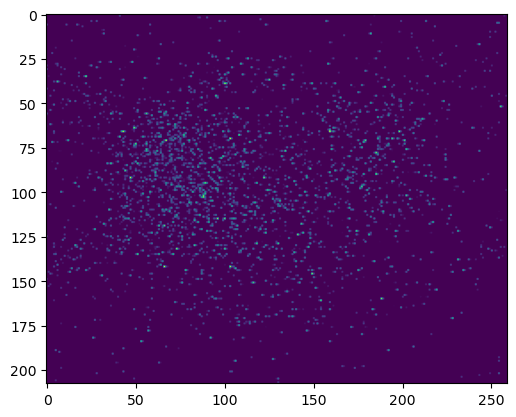

In [12]:
fig, ax = plt.subplots()
ax.imshow(np.amax(stack[100,:,:,:],axis=0))

In [ ]:
stack.shape

In [ ]:
(1,)*3

In [ ]:
base = basename_input
cycle = 0
channel = 2
frame = 1
fname = str(base) + f'_Cycle{cycle+1:05d}_Ch{channel}_{frame+1:06d}.ome.tif'

In [ ]:
os.path.exists(fname)

In [ ]:
dtype = skimread(fname).dtype

In [ ]:
imread = dask.delayed(skimread, pure=True)

In [ ]:
lazy_image = imread(fname)
sample = lazy_image.compute()
arr = da.from_delayed(lazy_image, dtype=sample.dtype, shape=sample.shape)

In [ ]:

lazy_image = dask.delayed(imread)(fname)
arr = da.from_delayed(lazy_image, (metadata['size']['y_px'], metadata['size']['x_px']), dtype=dtype)

In [ ]:
arr = lazy_image.compute()

In [ ]:
arr.shape